In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

# The Vanilla “Value” Object

This is the very core of everything, pay close attention to this data structure as it is really what enables everything else. 

We build the `Value` object to encapsulate scalar values and their gradients, and automatically constructing a DAG (Directed Acyclic Graph) to represent the computational graph. 

Given a mathematical expression, we see it as a series of composite functions and we chain them together in an ordered DAG. Why do we need this thing? ***Because of the chain rule.*** Backpropagation relies on the chain rule, which in turns require gradients to be propagated backwards through each operation in reverse order. A DAG data structure allows us to maintain the right topological order of operations and the dependencies between them so that we can calculate gradients in the correct sequence, while being general enough to represent any computation. 

Each `Value` *node* stores:

- Its own Data
- References to its “children” nodes (inputs to the operation that produced itself)
- The type of operation that produced itself
- A backward function to compute the (local) gradients

Again, in this way we are able to build up mathematical expression (+ and *) and build a graph of the “forward pass”. this is what we would run backpropagation on. backprop is just a recursive application of chain rule backwards on the computational graph.

**This notebook focues on the machinery needed to enable the "forward pass" first and foremost. The notebook titled `value_backward` moves on to extend the data structure to include the machinery for the backpropagation, building upon the concepts introduced in  `derivatives_intuition`**

In [3]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self): #print nicer looking expression for the value object
        return f"Value(data={self.data})"

In [4]:
a = Value(2.0)
a

Value(data=2.0)

In [5]:
# this cell produces an error because Python does not know yet how to add two Value objects 
a = Value(2.0)
b = Value(-3.0)
a +b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

## Defining the basic operations

We start by defining operations between Value objects. Python does not know how to e.g. “add” together two (or more) `Value` objects, we just invented this new thing in town, so we need to tell python how to do that. We do it by defining the `__add__` and `__mul__` methods inside the `Value` class

### Defining the basic operations

We start by defining operations between Value objects. Python does not know how to e.g. “add” together two (or more) `Value` objects, we just invented this new thing in town, so we need to tell python how to do that. We do it by defining the `__add__` method inside the `Value` class

In [6]:
class Value:

    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out 
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

In [11]:
a = Value(2.0)
b = Value(-3.0)
print('a + b = ', a + b)
print('a * b = ', a * b)

a + b =  value(data=-1.0)
a * b =  value(data=-6.0)


## Building the DAG

What we are still lacking is the “connective” tissue of the graph structure, we have nodes, but we do not have edges. We need both in order to keep track of the right order of computations and be able to apply backprop effectively in the future. So we need to:

- Know and keep pointers (references) about what values produce other values
- Know and keep track of what “type” of operation created a specific node
- Modify the defined operations to populate the set of children, and store the operation type that created them

In [19]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label # this is mainly for visualization purposes later
    
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out 
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [20]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c

print(d)
print('children', d._prev)
print('operation', d._op)

value(data=4.0)
children {value(data=-6.0), value(data=10.0)}
operation +


### Visualizing the DAG

Now it’s a good moment to visualize the data structure we have been building. We are able to build scalar valued mathematical expressions using only + and * so far,  and we can perform a “forward pass” to construct a DAG of operations that constitute the mathematical expression. operations).

In [21]:
# visualization code 

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [28]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

value(data=-8.0)

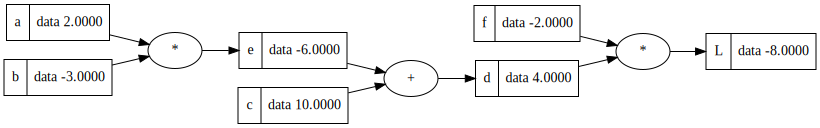

In [27]:
draw_dot(L)

Recap: we are able to build mathematical expressions (using only + and * so far), they are scalar valued, and we can do a forward pass and build out a mathematical expression that produces a single outout (L), and produce a graph of all the operations that led to that output. 

### Extending Value with More Operations

Now we want to extend the `Value` class so that it can support more operations than just simply + and *. This allows us to build more complex mathematical expressions. We include code to ensure that operations between `Value` objects and simple numbers are supported as well

In [29]:
# Extending the Value class to support more operations
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        return out 
    
    def __radd__(self, other):  # For handling float + Value
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        return out    
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self): # - self
        return self * -1 

    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out
    
    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self, ), 'exp')
        return out 


In [30]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b; d.label = 'd'
e = a + c; e.label = 'e'
f = (d / e)**2 ; f.label = 'f'
L = f * Value(-2.0, label='g'); L.label = 'L'
L

Value(data=-0.5)

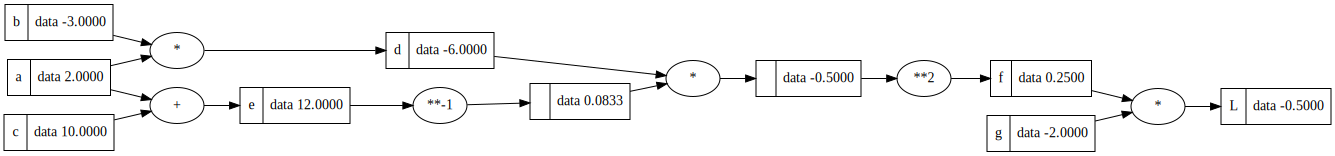

In [31]:
draw_dot(L)